# Evaluating Dribbling Ability

# Table of contents
1. [Introduction](#introduction)
2. [Data Source](#source)
    1. [Data Retrieval](#retrieval)
    2. [Data Processing](#processing)
3. [Evaluating risk of carry](#risk)
    1. [Defining new variables for carries](#risk1)
    2. [Defining a new pressure metric for carries](#risk2)
    3. [Visualizing carry success probabilities](#risk3)
    4. [Training a model to predict success probabilities](#risk4)
4. [Evaluating value of carry](#value)
    1. [Introducing pressure delta](#value1)
    2. [Defining the value metric](#value2)
5. [Carries: risk vs. value](#results)
    1. [Positions](#results1)
    2. [Players](#results2)

# Introduction <a class='anchor' id='introduction'></a>
This notebook contains a pipeline to evaluate carries with respect to their risk (probability of failure based on similar carries) and value (combination of advance towards goal and reduction of opponent pressure).

# Data Source <a class='anchor' id='source'></a>
We use open source data from Statsbomb, which can be imported using the mplsoccer package. 

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
%autoreload
import warnings
warnings.filterwarnings("ignore")

import matplotlib

## Data Retrieval <a class='anchor' id='retrieval'></a>
We retrieve as many of the 52 matches of the Women's World Cup 2023.

In [4]:
events = events.reset_index()

In [5]:
events.shape

(218902, 17)

In [6]:
events[events['type_name'] == 'Carry'].shape

(46789, 17)

In [7]:
events['outcome_name'].value_counts()

Incomplete               24995
Out                       1475
Won                       1316
Success In Play           1163
Complete                  1109
Lost In Play               943
Lost Out                   829
Off T                      517
Tactical                   459
Blocked                    406
Saved                      350
Success                    263
Unknown                    229
Lost                       185
No Touch                   162
Pass Offside               160
In Play Danger             143
Goal                       134
Wayward                    116
Success Out                103
Claim                       94
In Play Safe                85
Touched Out                 77
Success To Team             65
Saved Twice                 45
Success To Opposition       41
Injury                      35
Clear                       35
Post                        30
Injury Clearance            24
Touched In                  22
Punched out                 11
Collecte

## Evaluating risk of carry <a class='anchor' id='risk'></a>
In this section, the risk of a carry is determined by training a XGBoost model to predict the probability p of failure of a particular carry. The risk will then be defined as p, since a high probability of failure implies a high risk and a low probability of failure implies a low risk.

### Defining new variables for carries <a class='anchor' id='risk1'></a>
In the following functions, we define what constitutes a success for a carry, because the Outcome-label of the data is not sufficient as it is rarely filled. Thus we are often looking at the following event to check if a carry was successful. For example, if a player completes a pass after a carry, the carry is evaluated as successful.

Note: The definitions for success and failure are tailor-made for carries and cannot simply be transferred to other event data like passes. However, we need to include all event data in the first place order to obtain an appropriate temporal granularity.

Note: We thought about eliminating events for which the next event is more than ten seconds away. Looking into the data, this was not necessary! Sometimes there are long carries - i.e. from the goalkeeper. More often those carries are unsuccessful - and were labeled as such.

In [8]:
events.sort_values(["match_id", "period",  "minute", "second"], inplace=True)

rel_events = events[~events["type_name"].isin(["Pressure", "Duel"])]
rel_events["gametime_in_seconds"] = events["minute"] * 60 + events["second"]

shifted_events = rel_events.shift(-1)
next_match_same_match = rel_events["match_id"] == shifted_events["match_id"]
next_player_same_player = rel_events["player_name"] ==shifted_events["player_name"]
next_team_same_team = rel_events["team_name"] ==shifted_events["team_name"]

success_events = ['Pass','Goal','Dribble','Shot', "Carry", "Ball Receipt", "Foul Won"]
next_success = shifted_events["type_name"].isin(success_events)

unsuccessful_events = ["Miscontrol", "Dispossessed", "Interception"]
next_lost_ball = shifted_events["type_name"].isin(unsuccessful_events)

ball_recovery_by_opponent = ["Ball Recovery", "Block", "Collected"]
next_ball_recovery_event = shifted_events["type_name"].isin(ball_recovery_by_opponent)

foul_by_opponent_or_dribbled_past = ["Foul Committed", "Dribbled Past"]
next_foul_by_opponent_or_dribbled_past = shifted_events["type_name"].isin(foul_by_opponent_or_dribbled_past)

successful_outcomes = ["Won", "Success In Play", "Claim", "Complete", "Saved", "Saved Twice", "Success To Team", "Goal"]
unsuccessful_outcomes = ["Incomplete", "Lost", "Lost Out", "Lost In Play", "Off T", "Out", "Pass Offside"]

event_more_than_ten_seconds_away = shifted_events["gametime_in_seconds"] - rel_events["gametime_in_seconds"]   > 10

rel_events["Outcome"] = np.where(
    rel_events["outcome_name"].isin(successful_outcomes), 1, 
    np.where(rel_events["outcome_name"].isin(unsuccessful_outcomes), 0, 
             np.where(next_match_same_match & next_team_same_team & next_success, 1,
                      np.where(next_match_same_match & next_player_same_player & next_lost_ball ,0,
                               np.where(next_match_same_match & (~next_team_same_team) & next_success, 0,
                                        np.where(next_match_same_match & (~next_team_same_team) & next_ball_recovery_event, 0,
                                                 np.where(next_match_same_match & (~next_team_same_team) & next_foul_by_opponent_or_dribbled_past, 1,
                                                 2)))))))



In [9]:
events = events.merge(rel_events[["match_id", "id", "Outcome"]], how = "left", on = ["match_id", "id"], 
                     validate ="one_to_one")

# Calculating metrics based on active player

In [10]:
events.sort_values(["match_id", "id"], inplace=True)

rel_events = events[events["type_name"] != "Pressure"]

shifted_events = rel_events.shift(-1)
next_match_same_match = rel_events["match_id"] == shifted_events["match_id"]
next_player_same_player = rel_events["player_name"] ==shifted_events["player_name"]
next_success = shifted_events["type_name"].isin(['Pass','Goal','Dribble','Shot'])

next_miscontrol = shifted_events["type_name"]== "Miscontrol"


rel_events["Outcome_new"] = np.where(next_match_same_match & next_player_same_player & next_success, 1,
                                np.where(next_match_same_match & next_player_same_player & next_miscontrol ,0 ,2))

In [11]:
active_player_positions = frames[frames["actor"]].drop(columns = ["teammate", "actor"])
other_positions =  frames[~frames["actor"]]

In [12]:
# this should not be necessary, but due to a data error one player has two positions for one event
active_player_positions.drop_duplicates(subset = ["match_id", "id"], keep="first", inplace=True)

In [13]:
all_positions = other_positions.merge(active_player_positions, on = ["match_id", "id"], 
                            validate = "many_to_one", suffixes = ("", "_active_player"))


In [14]:
all_positions["distance_to_active_player"] = np.sqrt(
    (all_positions["x"] - all_positions["x_active_player"])**2 + 
    (all_positions["y"] - all_positions["y_active_player"])**2)


In [15]:
all_positions["player_within_5m"] = all_positions["distance_to_active_player"]<=5
all_positions["player_within_10m"] = all_positions["distance_to_active_player"]<=10
all_positions["player_within_20m"] = all_positions["distance_to_active_player"]<=20
all_positions["Pressure_Metric"] = np.where(all_positions["player_within_5m"], 1/all_positions["distance_to_active_player"], 0 )
all_positions["player_closer_to_attacked_goal"] = all_positions["x"] >= all_positions["x_active_player"]
all_positions["player_in_positions"] = 1

In [16]:
metrics_helper = all_positions.groupby(["match_id", "id", "teammate"], as_index=False).sum()

In [17]:
own_team_metrics = metrics_helper[metrics_helper["teammate"]]
other_team_metrics = metrics_helper[~metrics_helper["teammate"]]
metrics = other_team_metrics.merge(own_team_metrics, on = ["match_id", "id"], suffixes = ("", "_own_team"), 
                                  validate = "one_to_one", how = "left")


In [18]:
metrics["numerical_superiority_5m"] = metrics["player_within_5m_own_team"] - metrics["player_within_5m"]
metrics["numerical_superiority_10m"] = metrics["player_within_10m_own_team"] - metrics["player_within_10m"]
metrics["numerical_superiority_20m"] = metrics["player_within_20m_own_team"] - metrics["player_within_20m"]
metrics["opponents_within_5m"] =metrics["player_within_5m"]
metrics["opponents_within_10m"] =metrics["player_within_10m"]
metrics["opponents_within_20m"] =metrics["player_within_20m"]
metrics["opponents_closer_to_attacked_goal"] = metrics["player_closer_to_attacked_goal"]
metrics["opponents_in_data"] = metrics["player_in_positions"]

In [19]:
metrics_list = ["numerical_superiority_5m", "numerical_superiority_10m",
               "opponents_within_5m", "opponents_within_10m",
               "Pressure_Metric"]
feature_list = ["opponents_closer_to_attacked_goal", "opponents_in_data"]

In [20]:
metrics = metrics[["match_id", "id"] + metrics_list + feature_list]

In [21]:
metrics.head(2)

,match_id,id,numerical_superiority_5m,numerical_superiority_10m,opponents_within_5m,opponents_within_10m,Pressure_Metric,opponents_closer_to_attacked_goal,opponents_in_data
0,3893787,001bc880-a4c9-47bc-86c0-74bd7a84c346,-1.0,-2.0,1,2,0.369867,3,7
1,3893787,0027f1d1-a13a-42e1-9dde-81cedba718f9,-1.0,-2.0,1,2,0.563274,5,6


### Defining an advanced pressure metric for carries <a class='anchor' id='risk2'></a>
We define the pressure on the ball-carrier in a different and more elaborate sense than before. In order to do so, we draw upon the spatial position data and, for each frame, consider all players within a radius of five meters to the carrier. Then, we add up the reciprocals of the distances (a small distance adds a higher value to the pressure variable). In a later step, those values are normalized in relation to the calculated values for all other events.

In [22]:
events = events.merge(metrics, on = ["match_id", "id"], how = "left", validate = "one_to_one").fillna(0)
events

,index,match_id,id,period,minute,second,type_name,sub_type_name,player_name,x,...,under_pressure,position_name,Outcome,numerical_superiority_5m,numerical_superiority_10m,opponents_within_5m,opponents_within_10m,Pressure_Metric,opponents_closer_to_attacked_goal,opponents_in_data
0,2890,3893787,001bc880-a4c9-47bc-86c0-74bd7a84c346,2,85,59,Pass,0,Paige Therese Satchell,109.6,...,0.0,Left Center Forward,1.0,-1.0,-2.0,1.0,2.0,0.369867,3.0,7.0
1,977,3893787,0027f1d1-a13a-42e1-9dde-81cedba718f9,1,26,28,Duel,Aerial Lost,Hannah Wilkinson,96.4,...,1.0,Left Center Forward,0.0,-1.0,-2.0,1.0,2.0,0.563274,5.0,6.0
2,111,3893787,004f0bc4-3734-44a6-983b-c6d7d3caed17,1,3,11,Pressure,0,Julie Blakstad,99.2,...,0.0,Left Midfield,0.0,-2.0,-1.0,3.0,3.0,0.894467,5.0,10.0
3,1247,3893787,005a0896-bd92-4543-b8db-8172b5649fd1,1,34,21,Carry,0,Katie Bowen,38.6,...,0.0,Left Center Back,1.0,0.0,0.0,0.0,0.0,0.000000,4.0,4.0
4,655,3893787,00858141-8936-42b7-b353-1ce19b93b3d7,1,17,10,Ball Receipt,0,Thea Bjelde,31.2,...,0.0,Right Back,1.0,0.0,-1.0,0.0,1.0,0.000000,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218897,921,3906390,ffbc42fc-6b49-434f-9426-e7bae0cad38b,1,21,24,Pass,0,Olga Carmona García,17.5,...,0.0,Left Back,1.0,0.0,-1.0,0.0,3.0,0.000000,6.0,8.0
218898,1530,3906390,ffc36028-cbcc-4214-8958-f7080e13558d,1,37,57,Carry,0,Mary Alexandra Earps,3.7,...,1.0,Goalkeeper,1.0,0.0,0.0,0.0,0.0,0.000000,2.0,2.0
218899,694,3906390,ffe0d2b6-4c68-4a36-8164-c33a314275cd,1,16,49,Carry,0,Keira Walsh,9.4,...,1.0,Left Defensive Midfield,1.0,0.0,4.0,0.0,2.0,0.000000,2.0,4.0
218900,937,3906390,ffe6deb3-d16c-4875-99c7-b3d2276e1911,1,22,0,Pressure,0,Aitana Bonmati Conca,97.3,...,0.0,Right Center Midfield,0.0,-1.0,-1.0,1.0,1.0,0.353476,3.0,4.0


In [23]:
### Summarizing the new variable

print(np.min(events['Pressure_Metric']))
print(np.mean(events['Pressure_Metric']))
print(np.max(events['Pressure_Metric']))

0.0
0.444391648909691
44.48093027639916


Based on the advanced pressure metric, we determine how much pressure changes in the course of an event. The pressure delta hence indicates if a player is able to resolve pressure with their action/carry (negative pressure delta), or if they maneuver into pressure (positive pressure delta).
This metric will be used later in the section on the value of a carry.

In [24]:
events.sort_values(["match_id", "period", "minute", "second"],inplace=True)
shifted_events = events.shift(-1)

events["Pressure_Delta"]= np.where(events["match_id"] == shifted_events["match_id"],
                                  shifted_events["Pressure_Metric"] - events["Pressure_Metric"], np.nan)
events["Defending_Opponents_Delta"]= np.where(events["match_id"] == shifted_events["match_id"],
                                  shifted_events["opponents_closer_to_attacked_goal"] - events["opponents_closer_to_attacked_goal"], np.nan)
events["Opponents_Visiblity_Delta"]= np.where(events["match_id"] == shifted_events["match_id"],
                                  shifted_events["opponents_in_data"] - events["opponents_in_data"], np.nan)

In [25]:
events["Pressure"] = events["under_pressure"].fillna(0)

In [26]:
events['Pressure_Metric'] = np.where(events['Pressure_Metric']>0.5,1, events['Pressure_Metric']*2 )

# calculating more features based on following events

In [27]:
events["type_name"].unique()

array(['Half Start', 'Starting XI', 'Ball Receipt', 'Carry', 'Pass',
       'Pressure', 'Interception', 'Duel', 'Block', 'Ball Recovery',
       'Clearance', 'Dribble', 'Dispossessed', 'Miscontrol', 'Shot',
       'Goal Keeper', 'Offside', 'Dribbled Past', 'Foul Committed',
       'Foul Won', 'Shield', 'Half End', 'Substitution',
       'Injury Stoppage', '50/50', 'Player Off', 'Player On',
       'Bad Behaviour', 'Referee Ball-Drop', 'Tactical Shift', 'Error',
       'Own Goal Against', 'Own Goal For'], dtype=object)

In [28]:
doing_something_with_ball_events = ['Carry', 'Ball Receipt', 'Pass',
       'Duel', 'Ball Recovery', 'Miscontrol', 'Dribble',
       'Clearance', 'Foul Won', 'Dispossessed', 'Interception', 'Shot', 'Block',
       'Shield', 'Referee Ball-Drop', '50/50', 'Offside',  'Own Goal For']
not_doing_something_with_ball_events = ['Starting XI', 'Half Start', 'Pressure', 'Foul Committed',
       'Goal Keeper', 'Tactical Shift', 'Half End', 'Substitution','Dribbled Past',
       'Injury Stoppage', 'Error', 'Player Off',
       'Player On', 'Bad Behaviour', 
       'Own Goal Against']
if len([x for x in events["type_name"].unique() if x not in doing_something_with_ball_events + not_doing_something_with_ball_events]) > 0:
    raise Exception("Not all events were classified")
if len([x for x in doing_something_with_ball_events + not_doing_something_with_ball_events if x not in events["type_name"].unique()]) > 0:
    raise Exception("Not all events were classified 2")
if len([x for x in doing_something_with_ball_events if x in not_doing_something_with_ball_events]) > 0:
    print([x for x in doing_something_with_ball_events if x in not_doing_something_with_ball_events])
    raise Exception("Not all events were classified 3")
    
active_events_to_eval_if_success_within_next_events = ['Carry', 'Pass',
       'Duel', 'Ball Recovery', 'Miscontrol', 'Dribble', 'Clearance', 'Foul Won',
       'Interception', 'Shot', 'Block', 'Shield', 'Referee Ball-Drop', '50/50', 'Offside',  'Own Goal For']
ignored_doing_something_with_ball_events = [
    'Ball Receipt', "Dispossessed", 
]
if len(active_events_to_eval_if_success_within_next_events) + len(ignored_doing_something_with_ball_events) != len(doing_something_with_ball_events):
    raise Exception("Not all events were classified here")

# calculate metrics based on event

In [29]:
events["dribbling_towards_opponent_goal"] = (events["end_x"] > events["x"])*1

In [30]:
events.head(2)

,index,match_id,id,period,minute,second,type_name,sub_type_name,player_name,x,...,opponents_within_5m,opponents_within_10m,Pressure_Metric,opponents_closer_to_attacked_goal,opponents_in_data,Pressure_Delta,Defending_Opponents_Delta,Opponents_Visiblity_Delta,Pressure,dribbling_towards_opponent_goal
20,2,3893787,01cf8840-d0f8-464a-ba89-c156b67f86bb,1,0,0,Half Start,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
372,0,3893787,214905b4-b4ae-46cf-872d-8d07fa95386c,1,0,0,Starting XI,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Visualizing carry success probabilities <a class='anchor' id='risk4'></a>

In [31]:
pitch = Pitch(pitch_type='statsbomb',line_zorder=2)
bins = (pitch.dim.positional_x, pitch.dim.positional_y)
bins = (np.array([0.,40.,80.,120.]),np.array([0.,18.,30.,50.,62.,80.])) 

In [32]:
carries = events[events['type_name'].isin(["Dribble", "Carry"])]
carries = carries[carries['Outcome'].isin([0,1])]

In [33]:
carry_probability = pitch.bin_statistic(carries['x'], carries['y'], values=carries['Outcome'],
                                          statistic='mean', bins=bins)

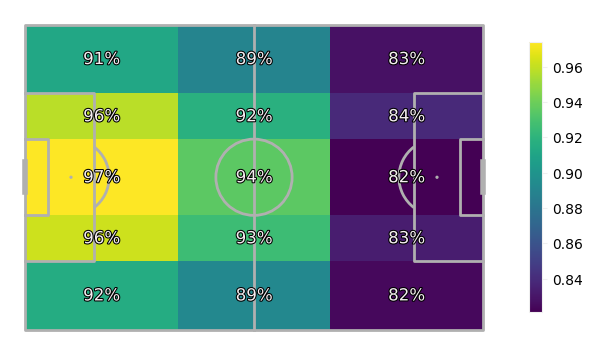

In [34]:
fig, ax = pitch.draw()
dribble_heatmap = pitch.heatmap(carry_probability, ax=ax)

cbar = fig.colorbar(dribble_heatmap, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
labels = pitch.label_heatmap(carry_probability, color='#f4edf0', fontsize=12,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

In [35]:
### Introducing a new variable to reflect vertical symmetry on the field and confirming Data Integrity

carries['y_symm'] = abs(carries['y']-40) # Note: the dimension of the statsbombpy pitch are 120x80
carries["y_upper_half"] = ((carries['y']-40) > 0 )*1

print(carries['Outcome'].isna().value_counts())
print(carries['x'].isna().value_counts())
print(carries['y'].isna().value_counts())
print(carries['y_symm'].isna().value_counts())

False    48782
Name: Outcome, dtype: int64
False    48782
Name: x, dtype: int64
False    48782
Name: y, dtype: int64
False    48782
Name: y_symm, dtype: int64


### Training a model to predict success probabilities <a class='anchor' id='risk5'></a>

We train a XGBoost model on input features to obtain predictions for success probabilities of a carry based on its characteristics (such as position on the field).

Note: We tried several other classifiers as well, XGB performed best. Hyperparameter and feature optimization was also done.

In [36]:
carries = carries.reset_index().drop(['index','level_0'],axis = 1)
carry_training_data = carries.copy()

In [37]:
carry_training_data["Outcome"].value_counts()

1.0    43802
0.0     4980
Name: Outcome, dtype: int64

In [38]:
### Normalizing the model input

def normalize(input_series):
    series = input_series.copy()
    max = np.max(series)
    min = np.min(series)
    for i in range(len(series)):
        series.loc[i] = (series.loc[i]-min) / (max-min) 
    return series

features were optimized before, correlated and unuseful features (such as opponents_within_10m, which could not improve the model) were removed. Thus the final features can be seen in the following:

In [69]:
### Creating training and test data

## features were optimized before, correlated 
## and unuseful features (such as opponents_within_10m, which could not improve the model) were removed

features = ['x','y_symm',
            "dribbling_towards_opponent_goal", "numerical_superiority_10m", "Pressure_Metric"]
target = ['Outcome']

for feature in features:
    carry_training_data[feature] = normalize(carry_training_data[feature] )

X = carry_training_data[features]
y = carry_training_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training and 30% test

[0]	validation_0-logloss:0.69207	validation_1-logloss:0.69240
[1]	validation_0-logloss:0.69327	validation_1-logloss:0.69393
[2]	validation_0-logloss:0.69599	validation_1-logloss:0.69667
[3]	validation_0-logloss:0.70007	validation_1-logloss:0.70106
[4]	validation_0-logloss:0.70434	validation_1-logloss:0.70555
[5]	validation_0-logloss:0.70979	validation_1-logloss:0.71159
[6]	validation_0-logloss:0.71573	validation_1-logloss:0.71766
[7]	validation_0-logloss:0.72119	validation_1-logloss:0.72338
[8]	validation_0-logloss:0.72698	validation_1-logloss:0.72949
[9]	validation_0-logloss:0.73270	validation_1-logloss:0.73543
[10]	validation_0-logloss:0.73842	validation_1-logloss:0.74148
[11]	validation_0-logloss:0.74386	validation_1-logloss:0.74715
[12]	validation_0-logloss:0.74913	validation_1-logloss:0.75285
[13]	validation_0-logloss:0.75398	validation_1-logloss:0.75822
[14]	validation_0-logloss:0.75890	validation_1-logloss:0.76347
[15]	validation_0-logloss:0.76313	validation_1-logloss:0.76811
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

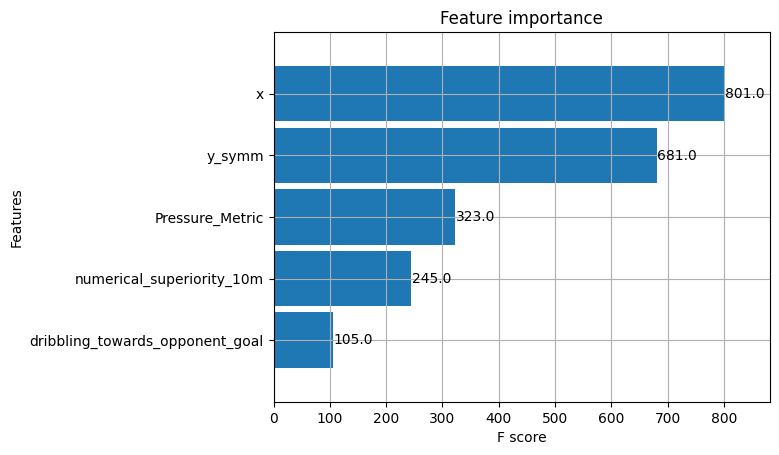

In [70]:

# Creating the XGB Classifier and training it on the training data

#file_name = "xgboost_carries.pkl"
#if os.path.exists(file_name):
#    xgb_model = pickle.load(open(file_name, "rb"))
#else:
xgb_model = xgb.XGBClassifier(n_estimators = 1000, eta = 0.1, scale_pos_weight=1/19)
xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, verbose = True)
#pickle.dump(xgb_model, open(file_name, "wb"))

xgb.plot_importance(xgb_model, height = 0.9)

The correlations show that the calculated pressure (here: Pressure_Metric) which measures the pressure at the beginning of an event is not too highly correlated with the Pressure from the event data. That is given by human labeling and thus indicates if there is pressure at any time of the carry. Both bring value to our model.

In [71]:
### correlation analysis

X.corr()

,x,y_symm,dribbling_towards_opponent_goal,numerical_superiority_10m,Pressure_Metric
x,1.000000,0.211734,-0.088892,-0.390197,0.229059
y_symm,0.211734,1.000000,-0.081732,-0.056525,0.053365
dribbling_towards_opponent_goal,-0.088892,-0.081732,1.000000,0.129459,-0.166567
numerical_superiority_10m,-0.390197,-0.056525,0.129459,1.000000,-0.423183
Pressure_Metric,0.229059,0.053365,-0.166567,-0.423183,1.000000


In [72]:
### Predicting the classes and class probailities for the test data events

pred_class = xgb_model.predict(X_test)
pred_probs = xgb_model.predict_proba(X_test)

In [73]:
def confusion_matrix_eval(y_truth, y_pred):
    cm = confusion_matrix(y_truth, y_pred)
    cr = classification_report(y_truth, y_pred)
    print(cr)
    print(cm)
confusion_matrix_eval(y_test, pred_class)

              precision    recall  f1-score   support

         0.0       0.15      0.91      0.26      1433
         1.0       0.98      0.44      0.61     13202

    accuracy                           0.49     14635
   macro avg       0.56      0.67      0.43     14635
weighted avg       0.90      0.49      0.57     14635

[[1304  129]
 [7398 5804]]


Evaluation shows that pressure is most important for carry success. Numerical superiority and location on the pitch is important as well, the dribbling direction is less important. All feature values influence the model as expected: Higher pressure, numerical minority and being close to the opponents goal for instance reduce the success of a carry.

In [74]:
### explainability of the XGBoost model: Shapley values


file_name = "xgboost_shap_values.pkl"
#if os.path.exists(file_name):
#    shap_values = pickle.load(open(file_name, "rb"))
#else:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
#pickle.dump(shap_values, open(file_name, "wb"))


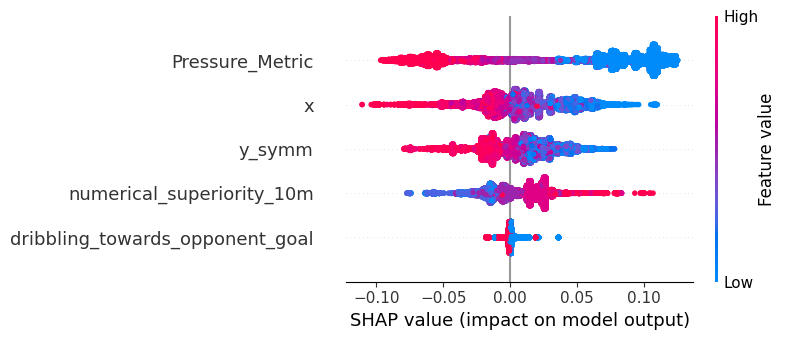

In [121]:
plt_shap = shap.summary_plot(shap_values,
                             features=X_train,
                             feature_names=X_train.columns,
                            show = False)
plt.show()

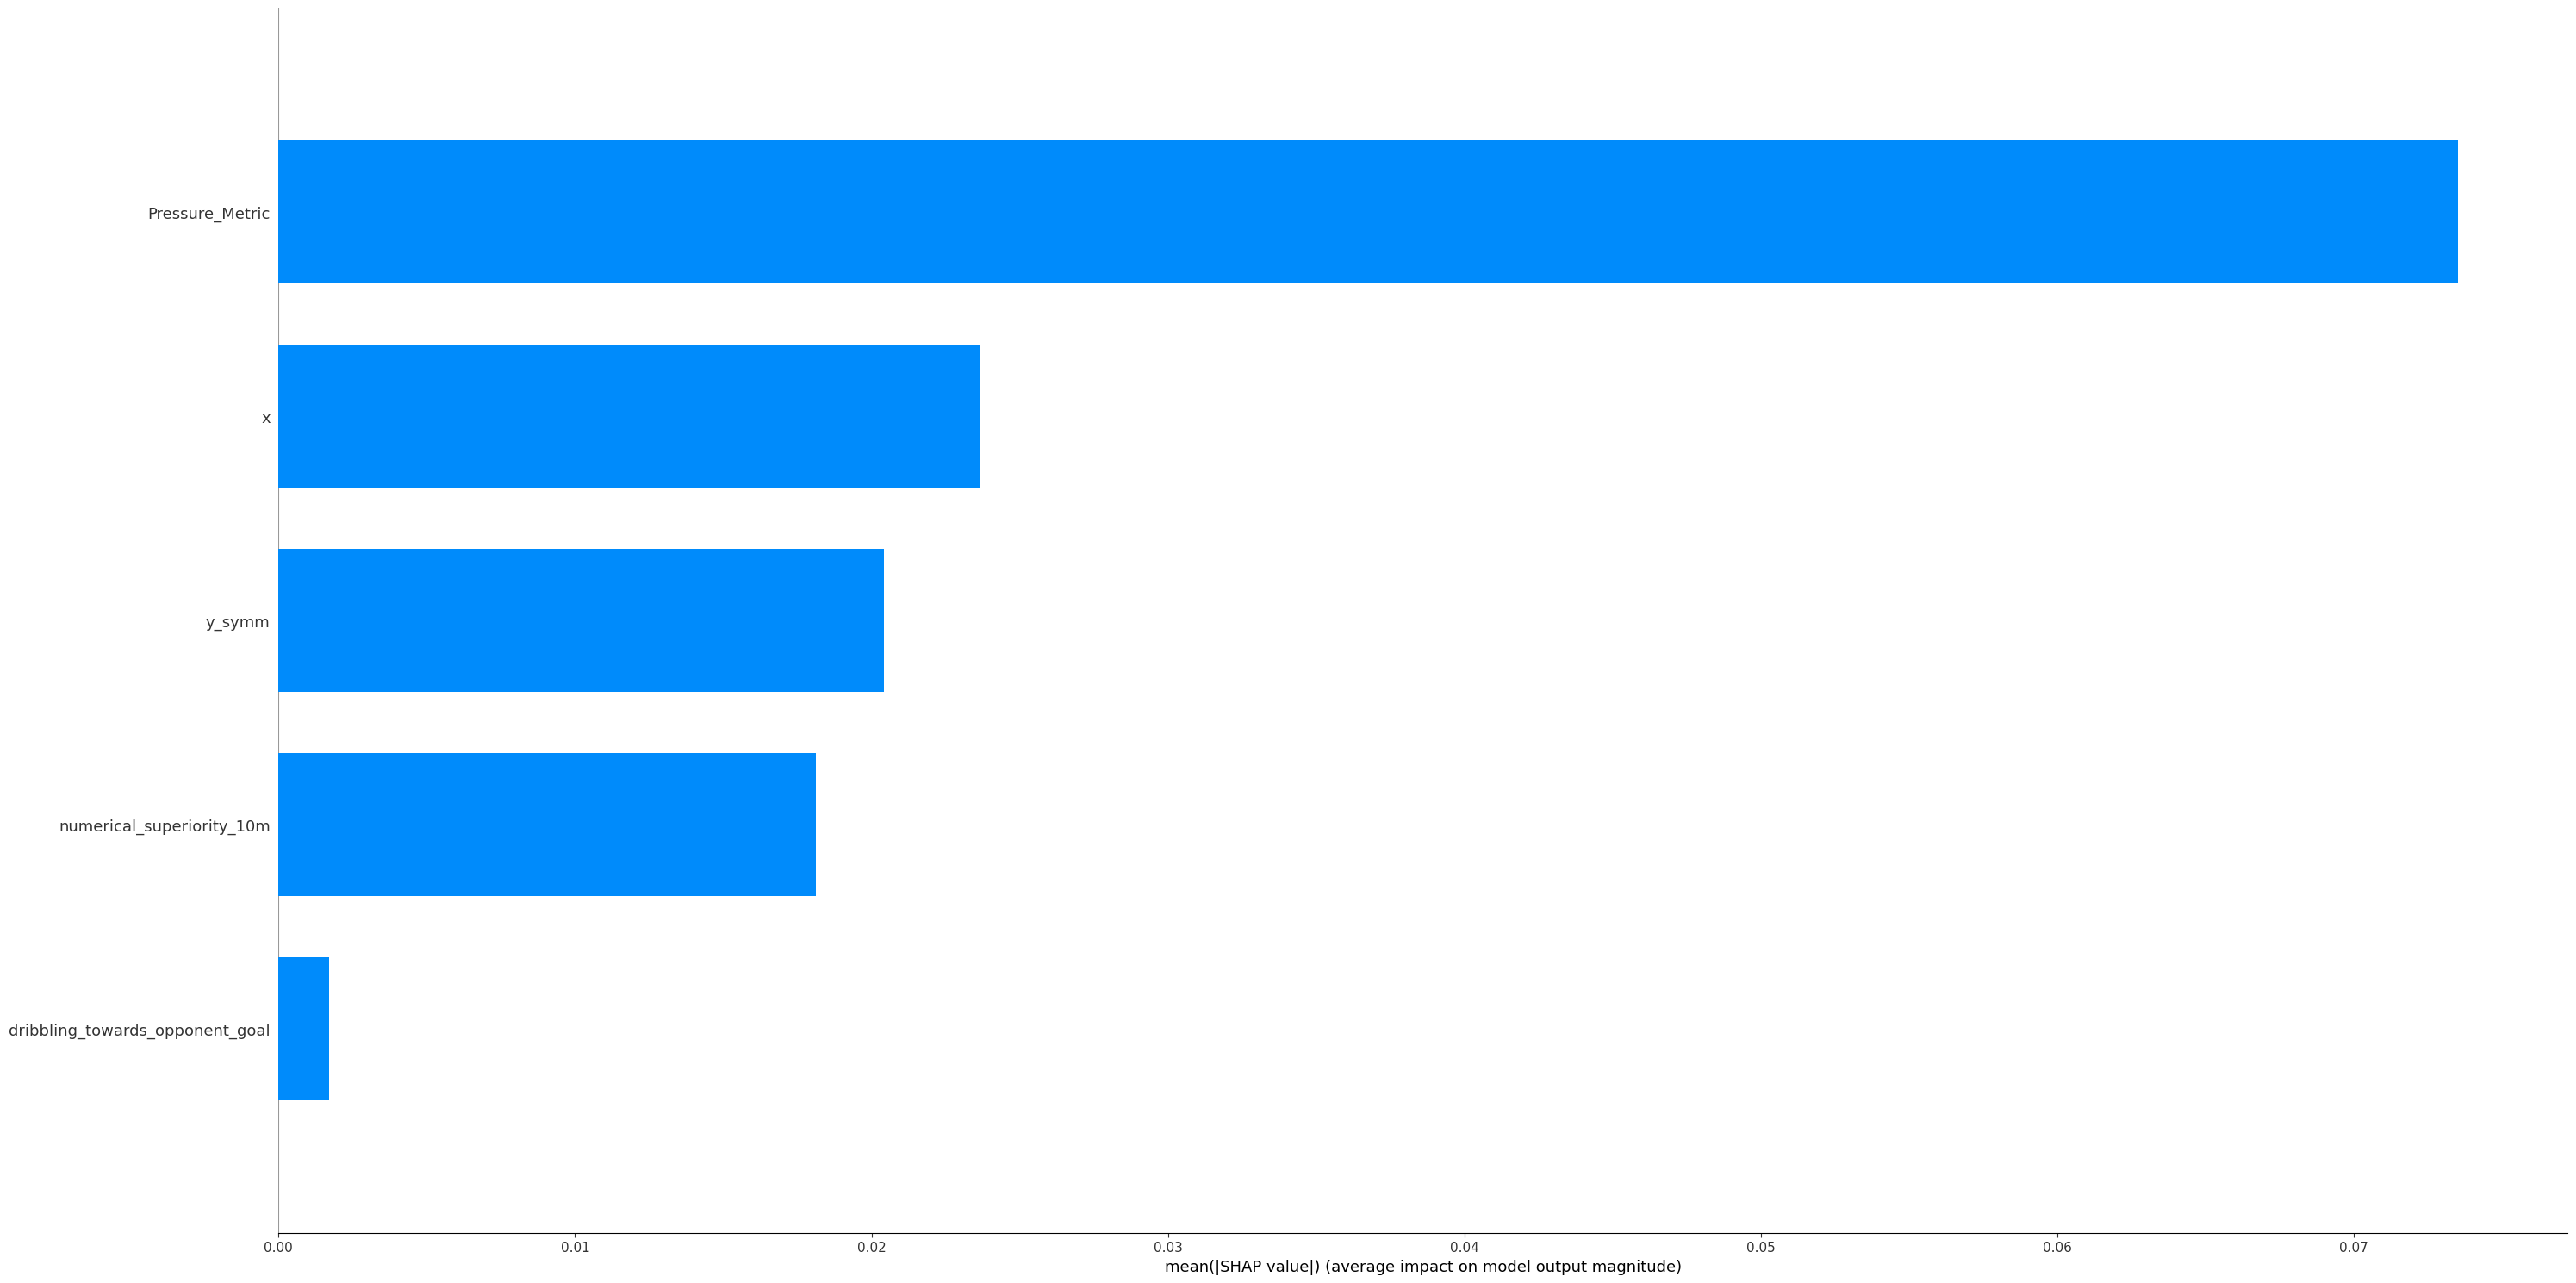

In [76]:
plt_shap = shap.summary_plot(shap_values,
                             features=X_train,
                             feature_names=X_train.columns,
                             plot_size=(30,15),
                            plot_type = "bar")

In [77]:
### predicting the outcome classes and probabilities for all carries in the dataset

pred_class = xgb_model.predict(X)
pred_probs = xgb_model.predict_proba(X)

carries['Outcome_Prediction'] = pred_class
carries['Risk'] = pred_probs[:,0] # extracting failure probability as risk
carries['Prob_Success'] = pred_probs[:,1]

Note: We had no access to publicly available tracking data (for the investigated matches). That could have helped investigate the success of dribblings here such as in https://doi.org/10.1080/24733938.2023.2239766. The methodoligy would stay the same though.

# Evaluating value of carry <a class='anchor' id='value'></a>
Having obtained a measure for the risk of a carry, we now determine the value of a carry. This is done based on the advance towards goal as well as change in opponent pressure contributed by the carry.

In [48]:
carries["advance_diff"] = np.sqrt((carries.x - 120)**2+(carries.y - 40)**2)  - np.sqrt((carries.end_x - 120)**2+(carries.end_y - 40)**2) 
carries["advance_diff"] = np.where((carries["end_x"]==0) & (0==carries["end_y"]), 0, carries["advance_diff"])

In [49]:
### summary of new variables

print("Summary: Pressure Delta")
print(np.min(carries['Pressure_Delta']))
print(np.mean(carries['Pressure_Delta']))
print(np.max(carries['Pressure_Delta']))
print("Summary: Advance (difference)")
print(np.min(carries['advance_diff']))
print(np.mean(carries['advance_diff']))
print(np.max(carries['advance_diff']))


Summary: Pressure Delta
-8.953479314656194
0.04439864837828402
12.585311447438368
Summary: Advance (difference)
-37.87466654634308
1.9136331140404357
64.61564257530705


In [50]:
# Normalizing the new variables to constitute the normed pressure delta and advance metric variables
carries['Pressure_Delta_Norm'] = normalize(carries['Pressure_Delta'] )
carries['Advance_Metric_Norm'] = normalize(carries['advance_diff'] )


In [51]:
carries['Pressure_Metric'].max()

1.0

## analyzing following events

In [52]:
carries[carries.columns.tolist() + ["Defending_Opponents_Delta","Opponents_Visiblity_Delta"]].head(3)

,match_id,id,period,minute,second,type_name,sub_type_name,player_name,x,y,...,y_symm,y_upper_half,Outcome_Prediction,Risk,Prob_Success,advance_diff,Pressure_Delta_Norm,Advance_Metric_Norm,Defending_Opponents_Delta,Opponents_Visiblity_Delta
0,3893787,8c3e1c8b-abc1-4f82-91ed-bcdf2e2990a8,1,0,0,Carry,0,Malia Grace Steinmetz,53.9,36.1,...,3.9,0,1,0.384627,0.615373,-1.047592,0.415691,0.359323,-10.0,-10.0
1,3893787,94d957c0-420e-4374-8072-d0e9a2bcc527,1,0,3,Carry,0,Catherine Joan Bott,34.1,62.5,...,22.5,1,1,0.384627,0.615373,4.711892,0.415691,0.415518,-1.0,0.0
2,3893787,adb09aca-b17a-4d77-b957-35b6789d9961,1,0,9,Carry,0,Julie Blakstad,46.5,11.2,...,28.8,0,0,0.526696,0.473304,-1.504828,0.420030,0.354861,5.0,5.0


# expected threat

The expected threat matrix was trained in another notebook on all availabe statsbomb data (a huge amount of data is crucial for an underlying xt-matrix).

In [53]:
def expected_threat_gain(x1: float or pd.Series, y1: float or pd.Series, x2: float or pd.Series,
                         y2: float or pd.Series, use_pressure_matrix=True) -> float or pd.Series:
    """
    Resets Index!
    Calculate the expected threat gain between (x1,y1) and (x2,y2)  for a statsbomb pitch

    :param x1: value or series/list of values of x coordinates (player1/ball)
    :param y1: value or series/list of values of y coordinates (player1/ball)
    :param x2: value or series/list of values of x coordinates (player2/ball)
    :param y2: value or series/list of values of y coordinates (player2/ball)

    :return: int or list/pd.Series of int (if list/pd.Series is given)
    """
    return expected_threat(x2, y2) - expected_threat(x1, y1)


def expected_threat(x1: float or pd.Series, y1: float or pd.Series, use_pressure_matrix=True) -> float or pd.Series:
    """
    Calculate the expected threat gain of (x1,y1) for a statsbomb pitch

    :param x1: value or series/list of values of x coordinates (player1/ball)
    :param y1: value or series/list of values of y coordinates (player1/ball)


    :return: int or list/pd.Series of int (if list/pd.Series is given)
    """
    if use_pressure_matrix:
        xt_matrix = pd.read_csv("xT_pressure.csv", index_col=0)
    else:
        xt_matrix = pd.read_csv("xT_no_pressure.csv", index_col=0)
    pitch_x_start = 0
    pitch_x_end = 120
    pitch_y_start = 0
    pitch_y_end = 80

    n_bins_x = xt_matrix.shape[1]
    n_bins_y = xt_matrix.shape[0]

    bin_size_x = (pitch_x_end - pitch_x_start) / n_bins_x
    bin_size_y = (pitch_y_end - pitch_y_start) / n_bins_y
    bin_x_borders = [pitch_x_start + bin_size_x * i for i in range(n_bins_x + 1)]
    bin_y_borders = [pitch_y_start + bin_size_y * i for i in range(n_bins_y + 1)]

    x_bins = pd.cut(x1, bin_x_borders, include_lowest=True).apply(lambda x: x.left).astype(float)
    x_bins = np.round(x_bins / bin_size_x)
    y_bins = pd.cut(y1, bin_y_borders, include_lowest=True).apply(lambda x: x.left).astype(float)
    y_bins = np.round(y_bins / bin_size_y)

    df_melt = xt_matrix.rename_axis('y').reset_index().melt(id_vars='y', var_name='x', value_name='xt')
    rel_bin = pd.DataFrame([x_bins, y_bins]).T
    rel_bin.columns = ["x", "y"]
    rel_bin["x"] = rel_bin["x"].astype(float)
    rel_bin["y"] = rel_bin["y"].astype(float)
    df_melt["x"] = df_melt["x"].astype(float)
    df_melt["y"] = df_melt["y"].astype(float)
    xt_result = rel_bin.merge(df_melt, on = ("x", "y"), how = "left", validate = "many_to_one")

    xt_vals = np.where((x1==0) &(y1==0), np.nan, xt_result["xt"].values)
    return xt_vals

In [54]:
def get_expected_threat_next_best_field(x1: float or pd.Series, y1: float or pd.Series, use_pressure_matrix=True) -> float or pd.Series:
    """
    Calculate the possible expected threat of (x1,y1) for a statsbomb pitch after a successful carry
    
    Assumption: player gets to the next best bin (closer to the goal)    

    :param x1: value or series/list of values of x coordinates (player1/ball)
    :param y1: value or series/list of values of y coordinates (player1/ball)


    :return: int or list/pd.Series of int (if list/pd.Series is given)
    """
    
    if use_pressure_matrix:
        xt_matrix = pd.read_csv("xT_pressure.csv", index_col=0)
    else:
        xt_matrix = pd.read_csv("xT_no_pressure.csv", index_col=0)
    pitch_x_start = 0
    pitch_x_end = 120
    pitch_y_start = 0
    pitch_y_end = 80

    n_bins_x = xt_matrix.shape[1]
    n_bins_y = xt_matrix.shape[0]
    bin_size_x = (pitch_x_end - pitch_x_start) / n_bins_x
    bin_size_y = (pitch_y_end - pitch_y_start) / n_bins_y
    
    x1 = np.where(x1 + bin_size_x < pitch_x_end, x1 + bin_size_x, x1)
    y1 = np.where(y1 < pitch_y_end/2, y1 + bin_size_y, y1 - bin_size_y)
    return expected_threat(pd.Series(x1), pd.Series(y1),use_pressure_matrix)

In [55]:
def get_expected_threat_opposition(x1: float or pd.Series, y1: float or pd.Series, use_pressure_matrix=True) -> float or pd.Series:
    """
    Calculate the possible expected threat of (x1,y1) for a statsbomb pitch after a successful carry
    
    Assumption: player gets to the next best bin (closer to the goal)    

    :param x1: value or series/list of values of x coordinates (player1/ball)
    :param y1: value or series/list of values of y coordinates (player1/ball)


    :return: int or list/pd.Series of int (if list/pd.Series is given)
    """

    pitch_x_end = 120
    
    x1 = pitch_x_end - x1
    return expected_threat(pd.Series(x1), pd.Series(y1), use_pressure_matrix)

In [56]:
carries["xt_gain_if_pressure"] = expected_threat_gain(carries["x"], carries["y"], carries["end_x"], carries["end_y"],True)
carries["xt_gain_if_no_pressure"] = expected_threat_gain(carries["x"], carries["y"], carries["end_x"], carries["end_y"],False)

In [57]:
carries["xT_start"] = expected_threat(carries["x"], carries["y"], True)*carries['Pressure_Metric'] + expected_threat(carries["x"], carries["y"], False) * (1-carries['Pressure_Metric'] )

In [58]:
carries['xT_end_no_pressure'] = np.where(carries['Outcome'] == 1, 
                     expected_threat(carries["end_x"], carries["end_y"], False), 
                     get_expected_threat_next_best_field(carries["x"], carries["y"], False))

In [59]:
carries['xT_end_pressure'] = np.where(carries['Outcome'] == 1, 
                     expected_threat(carries["end_x"], carries["end_y"], True), 
                     get_expected_threat_next_best_field(carries["x"], carries["y"], True))

In [60]:
carries['xT_end'] = np.maximum(carries['xT_end_no_pressure'], carries['xT_end_pressure'])
print(sum(carries['xT_end']))
carries['xT_end'] = np.where(carries['end_x'] == 0,
                            get_expected_threat_next_best_field(carries["x"], carries["y"], False),
                            carries['xT_end'])
print(sum(carries['xT_end']))

nan
510.4160992240891


In [61]:
carries['xT_opp'] = np.where(carries['Outcome'] == 0, 
                     get_expected_threat_opposition(carries["end_x"], carries["end_y"], True), 
                     get_expected_threat_opposition(carries["x"], carries["y"], True))

In [62]:
carries['xT_gain'] = np.where(carries['Outcome'] == 1,
                            carries['xT_end'] - carries['xT_start'],
                             -carries['xT_start'] - carries['xT_opp'])  

In [111]:
bins = (np.array([0.,20.,40.,60.,80.,98.,110.,120.]),np.array([0.,12.,30.,40.,50.,68.,80.])) 

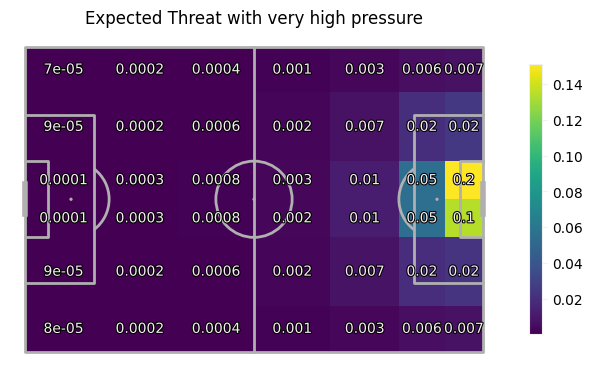

In [114]:
df_heatmap = carries[carries['Pressure_Metric']==1]

xt_start = pitch.bin_statistic(df_heatmap['x'], df_heatmap['y'], values=df_heatmap['xT_start'],
                                          statistic='mean', bins=bins)

fig, ax = pitch.draw()
dribble_heatmap = pitch.heatmap(xt_start, ax=ax)

cbar = fig.colorbar(dribble_heatmap, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
labels = pitch.label_heatmap(xt_start, color='#f4edf0', fontsize=10,
                             ax=ax, ha='center', va='center',
                             str_format='{:.1}', path_effects=path_eff)
plt.title("Expected Threat with very high pressure")

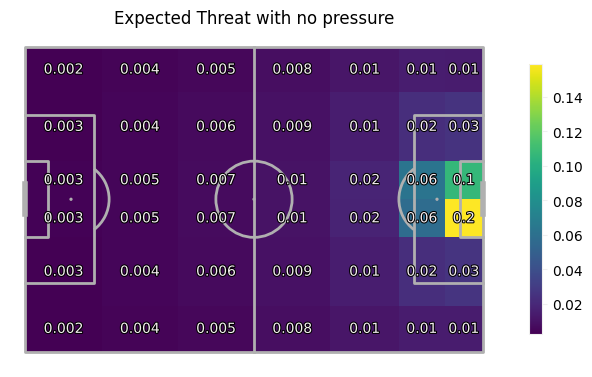

In [113]:
df_heatmap = carries[carries['Pressure_Metric']==0]

xt_start = pitch.bin_statistic(df_heatmap['x'], df_heatmap['y'], values=df_heatmap['xT_start'],
                                          statistic='mean', bins=bins)

fig, ax = pitch.draw()
dribble_heatmap = pitch.heatmap(xt_start, ax=ax)

cbar = fig.colorbar(dribble_heatmap, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
labels = pitch.label_heatmap(xt_start, color='#f4edf0', fontsize=10,
                             ax=ax, ha='center', va='center',
                             str_format='{:.1}', path_effects=path_eff)
plt.title("Expected Threat with no pressure")

In [115]:
bins = (np.array([0.,30.,60.,80.,102.,120.]),np.array([0.,12.,30.,40.,50.,68.,80.])) 

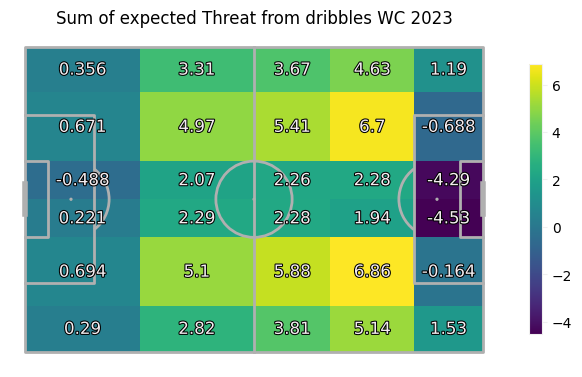

In [86]:
df_heatmap = carries
xt_start = pitch.bin_statistic(df_heatmap['x'], df_heatmap['y'], values=df_heatmap['xT_gain'],
                                          statistic='sum', bins=bins)
fig, ax = pitch.draw()
dribble_heatmap = pitch.heatmap(xt_start, ax=ax)

cbar = fig.colorbar(dribble_heatmap, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
labels = pitch.label_heatmap(xt_start, color='#f4edf0', fontsize=12,
                             ax=ax, ha='center', va='center',
                             str_format='{:.3}', path_effects=path_eff)
plt.title("Sum of expected Threat from dribbles WC 2023")

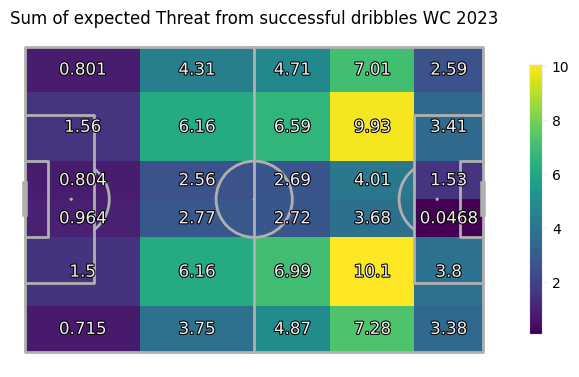

In [87]:
#Only successful dribblings

df_heatmap = carries[carries['Outcome'] == 1]

xt_start = pitch.bin_statistic(df_heatmap['x'], df_heatmap['y'], values=df_heatmap['xT_gain'],
                                          statistic='sum', bins=bins)

fig, ax = pitch.draw()
dribble_heatmap = pitch.heatmap(xt_start, ax=ax)

cbar = fig.colorbar(dribble_heatmap, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
labels = pitch.label_heatmap(xt_start, color='#f4edf0', fontsize=12,
                             ax=ax, ha='center', va='center',
                             str_format='{:.3}', path_effects=path_eff)
plt.title("Sum of expected Threat from successful dribbles WC 2023")

In [89]:
dribblings_germany = carries[carries['team_name'] == "Germany Women's"]
number_matches_germany = len(dribblings_germany['match_id'].unique())

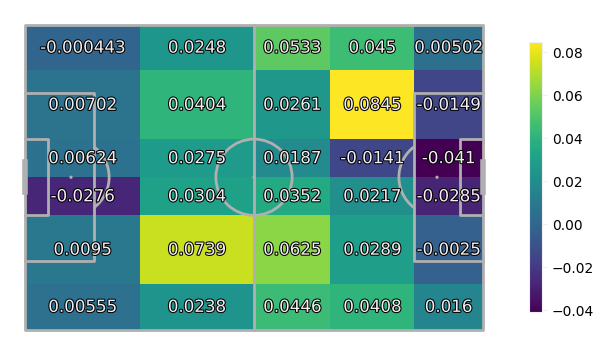

In [90]:

df_heatmap = dribblings_germany

xt_start = pitch.bin_statistic(df_heatmap['x'], df_heatmap['y'], values=df_heatmap['xT_gain']/number_matches_germany,
                                          statistic='sum', bins=bins)

fig, ax = pitch.draw()
dribble_heatmap = pitch.heatmap(xt_start, ax=ax)

cbar = fig.colorbar(dribble_heatmap, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
labels = pitch.label_heatmap(xt_start, color='#f4edf0', fontsize=12,
                             ax=ax, ha='center', va='center',
                             str_format='{:.3}', path_effects=path_eff)


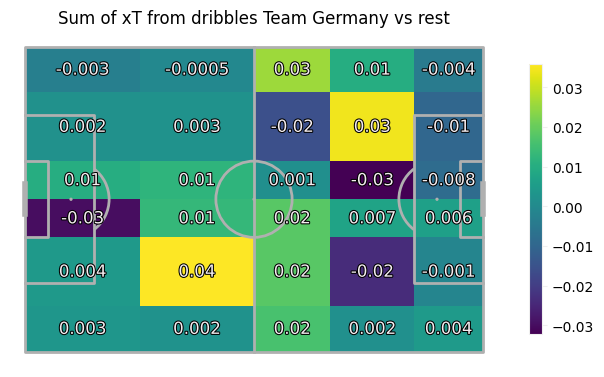

In [118]:

df_heatmap = dribblings_germany

xt_start = pitch.bin_statistic(df_heatmap['x'], df_heatmap['y'], values=df_heatmap['xT_gain']/number_matches_germany,
                                          statistic='sum', bins=bins)

df_heatmap = carries[~(carries['team_name'] == "Germany Women's")]
number_matches_all = len(df_heatmap['match_id'].unique()) * 2
xt_ec = pitch.bin_statistic(df_heatmap['x'], df_heatmap['y'], values=df_heatmap['xT_gain']/number_matches_all,
                                          statistic='sum', bins=bins)

xt_start['statistic'] = xt_start['statistic'] - xt_ec['statistic']
fig, ax = pitch.draw()
dribble_heatmap = pitch.heatmap(xt_start, ax=ax)

cbar = fig.colorbar(dribble_heatmap, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
labels = pitch.label_heatmap(xt_start, color='#f4edf0', fontsize=12,
                             ax=ax, ha='center', va='center',
                             str_format='{:.1}', path_effects=path_eff)
plt.title("Sum of xT from dribbles Team Germany vs rest")

In [ ]:
carries['xt_norm'] = normalize(carries['xT_gain'] )


# opponents behind ball

We tried to evaluate how many players were taken out of play by a dribbling. Unfortunately, the given position data is not sufficient for such analysis.

In [ ]:
frames

In [ ]:
frames_with_event_pos = frames.merge(events[["match_id", "id", "x", "y", "end_x", "end_y"]], how = "left", on = ["match_id", "id"],
                                    suffixes = ("_frames", "_events"), validate = "many_to_one")

In [ ]:
# keeper raus, da in einigen Fällen zu sehen aber i.d.R. sowieso hinterm Ball
opponents_behind_ball = frames_with_event_pos[(frames_with_event_pos["x_frames"] > frames_with_event_pos["x_events"]) &
                                             (~frames_with_event_pos["teammate"]) & (~frames_with_event_pos["keeper"])]

In [ ]:
number_opponents_per_events = opponents_behind_ball.groupby(["match_id", "id"], as_index=False)["teammate"].count()
number_opponents_per_events.columns = ["match_id", "id", "opponents_behind_ball"]

# vaep

In [ ]:
vaep_model_women = get_vaep_model(competition_id=competition_id, season_id=season_id)

In [ ]:
game_id = frames["match_id"].iloc[0]  
from_action = 0
number_actions_per_plot = 10
number_plots = 10

for i in range(from_action, from_action + number_actions_per_plot * number_plots, number_actions_per_plot):
    plot_actions(vaep_model_women, competition_id, season_id,
                 game_id=game_id,
                 from_action_number=i,
                 number_actions=10)

In [ ]:
all_vaep = list()
for game_id in tqdm(carries["match_id"].drop_duplicates()):
    tmp_vaep_values = get_vaep_values(vaep_model_women, competition_id, season_id, game_id)
    all_vaep.append(tmp_vaep_values)
df_vaep = pd.concat(all_vaep)

In [ ]:
df_vaep.rename(columns = {"original_event_id": "id", "game_id": "match_id"}, inplace=True)
df_vaep_merge = df_vaep[["match_id", "id", "offensive_value", "defensive_value", "vaep_value"]].dropna(subset = "id")
df_vaep.head(3)

In [ ]:
carries = carries.merge(df_vaep_merge, on = ["match_id", "id"], validate = "one_to_one", how = "left")
carries.head(3)

In [ ]:
carries['vaep_norm'] = normalize(carries['vaep_value'] )

# adding playing time

In [ ]:
def get_all_players_with_playing_minutes_per_position(match_id: str):
    lineups = sb.lineups(match_id)
    parser = Sbopen()
    events = parser.event(match_id)[0]
    max_period = events["period"].max()
    if max_period == 4:
        end_time = "120:00"
        full_time = 120
    else:
        end_time = "90:00"
        full_time = 90

    df_list = list()

    for team, lineup in lineups.items():
        for idx, row in lineup.iterrows():
            df_playing_time = _helper_get_playing_time_per_position(row, end_time)
            df_list.append(df_playing_time)
    df = pd.concat(df_list)
    df["playing_time_in_minutes"] = df["playing_time_in_seconds"] /60
    df["playing_ratio"] =  df["playing_time_in_minutes"]/full_time
    df.dropna(subset = "playing_ratio", inplace=True)
    return df


def _helper_get_playing_time_per_position(row, end_time)-> pd.DataFrame:
    if len(row["positions"]) == 0:
        return pd.DataFrame()
    df = pd.DataFrame(row["positions"])

    df["from"].fillna("0:00", inplace=True)
    df["to"].fillna(end_time, inplace=True)
    df["from_in_seconds"] = df["from"].str.split(":").apply(lambda x: x[0]).astype(int) * 60 + df["from"].str.split(
        ":").apply(lambda x: x[1]).astype(int)
    df["to_in_seconds"] = df["to"].str.split(":").apply(lambda x: x[0]).astype(int) * 60 + df["to"].str.split(
        ":").apply(lambda x: x[1]).astype(int)
    from_in_seconds = df["from_in_seconds"].min()
    to_in_seconds = df["to_in_seconds"].max()
    df["playing_time_in_seconds"] = df["to_in_seconds"] - df["from_in_seconds"]
    df_playing_time = df.groupby("position", as_index=False).sum()[["position", "playing_time_in_seconds"]]
    df_playing_time["player_id"] = row["player_id"]
    df_playing_time["player_name"] = row["player_name"]
    return df_playing_time

all_playing_times = list()
for match in tqdm(carries["match_id"].unique()):
    playing_time = get_all_players_with_playing_minutes_per_position(match)
    playing_time["match_id"] = match
    all_playing_times.append(playing_time)
df_playing_time = pd.concat(all_playing_times)

In [ ]:
df_playing_time.head(3)

In [ ]:
df_playing_time_merge = df_playing_time[["match_id", "player_id", "playing_time_in_minutes", "position"]]
df_playing_time.to_excel("playing_time_per_player_per_match.xlsx")

# store carry data

In [ ]:
carries.to_excel("carries.xlsx")